In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 5 days

    After the trial mode has expired, if you want to use mkl thereafter,
    please purchase a license at http://continuum.io
    


In [2]:
df = pd.read_csv("../main_15min_decomposition_12_daily_weekly_cluster_diff_frac_temp_weekday.csv", index_col=0)
df = df.drop(871)
df = df.drop(1169)
w=df[['aggregate_%d' %i for i in range(1,13)]]
dfc = df.copy()
df = df.ix[w[w>0].dropna().index]
max_aggregate = df[["aggregate_%d" % i for i in range(1, 13)]].max().max()
df[["aggregate_%d" % i for i in range(1, 13)]] = df[["aggregate_%d" % i for i in range(1, 13)]].div(max_aggregate)


max_weekly = df[["daily_usage_%d" % i for i in range(1, 8)]].max().max()
df[["daily_usage_%d" % i for i in range(1, 8)]] = df[["daily_usage_%d" % i for i in range(1, 8)]].div(max_weekly)

df['area'] = df['area'].div(df['area'].max())

df['num_rooms'] = df['num_rooms'].div(df['num_rooms'].max())
df['total_occupants'] = df['total_occupants'].div(df['total_occupants'].max())
df['mins_hvac'] =  df['mins_hvac'].div(df['mins_hvac'].max())

max_cols = {}
for col in ["stdev_trend_12","stdev_seasonal_12","max_seasonal_12","max_trend_12",
            "stdev_trend_daily","stdev_seasonal_daily","max_seasonal_daily","max_trend_daily",
            "stdev_trend_weekly","stdev_seasonal_weekly","max_seasonal_weekly","max_trend_weekly","disag_fridge",
            'stdev_trend','stdev_seasonal','max_seasonal','max_trend',
            'cluster_small','cluster_big', 'temperature_corr']:
    if col in df.columns:
        max_cols[col] = dfc[col].max()
        df[col] = df[col].div(df[col].max())
aa = df[["aggregate_%d" % i for i in range(1, 13)]].copy()
df['variance'] = df[["aggregate_%d" % i for i in range(1, 13)]].var(axis=1)
df['ratio_min_max'] = aa.min(axis=1)/aa.max(axis=1)

df['difference_min_max'] = aa.max(axis=1)-aa.min(axis=1)
df['ratio_difference_min_max'] = (aa.max(axis=1)-aa.min(axis=1)).div(aa.max(axis=1))

In [3]:
import statsmodels.api as sm


def decompose(df, freq=96):
    res = sm.tsa.seasonal_decompose(df.fillna(method='ffill').values, freq=freq)
    return pd.DataFrame({"seasonal":res.seasonal, "trend":res.trend, "obs":res.observed}, index=df.index)



In [4]:
df.describe()

,aggregate_1,aggregate_2,aggregate_3,aggregate_4,aggregate_5,aggregate_6,aggregate_7,aggregate_8,aggregate_9,aggregate_10,...,daily_usage_5,daily_usage_6,daily_usage_7,area,num_rooms,total_occupants,variance,ratio_min_max,difference_min_max,ratio_difference_min_max
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,...,57.000000,57.000000,57.000000,56.000000,56.000000,52.000000,57.000000,57.000000,57.000000,57.000000
mean,0.218754,0.175169,0.200288,0.204278,0.282759,0.418136,0.439046,0.493739,0.390751,0.254473,...,0.340635,0.356962,0.344012,0.574250,0.602679,0.511538,0.017012,0.320446,0.346339,0.679554
std,0.135996,0.106169,0.121484,0.122358,0.150816,0.187365,0.187626,0.207867,0.164047,0.134188,...,0.163864,0.154795,0.150095,0.178310,0.225849,0.232340,0.013090,0.101587,0.152108,0.101587
min,0.065169,0.050859,0.060874,0.070970,0.087910,0.104358,0.100985,0.082996,0.117798,0.078218,...,0.106601,0.127047,0.126329,0.274286,0.166667,0.000000,0.000194,0.119901,0.042386,0.251410
25%,0.134303,0.115163,0.112400,0.112888,0.169510,0.276252,0.296643,0.322065,0.245204,0.148273,...,0.201282,0.225741,0.219931,0.448500,0.416667,0.400000,0.006891,0.259591,0.234264,0.651133
50%,0.186758,0.146551,0.176726,0.187132,0.267250,0.384382,0.401293,0.501874,0.378830,0.215229,...,0.341980,0.348226,0.336916,0.571429,0.583333,0.400000,0.015204,0.308511,0.350552,0.691489
75%,0.243340,0.212305,0.251871,0.242627,0.351546,0.502331,0.538773,0.609595,0.492651,0.348059,...,0.413806,0.424348,0.409816,0.702500,0.770833,0.800000,0.023601,0.348867,0.432740,0.740409
max,0.932131,0.733477,0.749865,0.733155,0.784175,1.000000,0.940040,0.970850,0.869814,0.744823,...,1.000000,0.940866,0.920930,1.000000,1.000000,1.000000,0.060626,0.748590,0.730947,0.880099


In [5]:
features_individual = {'fraction':["fraction_%d" % i for i in range(1, 25)],
                       'area': 'area',
                       'autocorr':'autocorr',
                       'month': ["aggregate_%d" % i for i in range(1, 13)],
                       'occupants': 'total_occupants',
                       'rooms': 'num_rooms',
                       'seasonal_12':['stdev_seasonal_12','max_seasonal_12'],
                       'trend_12':['stdev_trend_12','max_trend_12'],
                       'seasonal_daily':['stdev_seasonal_daily','max_seasonal_daily'],
                       'trend_daily':['stdev_trend_daily','max_trend_daily'],
                       'seasonal_weekly':['stdev_seasonal_weekly','max_seasonal_weekly'],
                       'trend_weekly':['stdev_trend_weekly','max_trend_weekly'],
                       'disag_fridge':'disag_fridge',
                       'mins_hvac':'mins_hvac',
                       'cluster_big':'cluster_big',
                       'diff':['lt_500','bet_500_1000','gt_1000'],
                       'temp':'temperature_corr',
                       'month_extract':['variance','ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max']}

from itertools import combinations
features_dict = {}
for feature_size in range(1,max(4,len(features_individual))):
    combinations_size_n = list(combinations(features_individual.keys(), feature_size))
    for com in combinations_size_n:
        features_dict[com] = np.hstack([features_individual[x] for x in com]).tolist()


dfs = {}
total = features_dict.values()[np.array(map(len, features_dict.values())).argmax()]
for appliance in ['fridge','hvac','dr','light','dw','wm']:
    temp=df.ix[df[['%s_%d' %(appliance, i) for i in range(1,13)]].dropna().index]
    dfs[appliance] =temp.ix[temp[total].dropna().index]


all_homes = {appliance:dfs[appliance].index for appliance in dfs.keys()}
all_homes['fridge'] = np.array(np.setdiff1d(all_homes['fridge'], [2233, 5746, 7016]))
all_homes['hvac'] = np.array(np.setdiff1d(all_homes['hvac'], [252, 2925, 2986, 3482, 4732, 5439, 6266,
                                                              8626, 1800, 2233, 5817, 7016, 7429, 8317,
                                                              9052, 9982]))
all_homes['dw'] =  np.array(np.setdiff1d(all_homes['dw'],[2233, 7016]))
all_homes['wm'] = np.array([  94,  370,  545,  624, 2156, 2242, 2470, 2814, 3367, 3456, 3723,
            3967, 5357, 7769, 9654, 9922, 9934])


In [6]:
df_appl = {appl:df.ix[all_homes[appl]].copy() for appl in ['fridge','hvac','dr','light','dw','wm']}

In [7]:
df_appl['wm'].head()

,aggregate_1,aggregate_2,aggregate_3,aggregate_4,aggregate_5,aggregate_6,aggregate_7,aggregate_8,aggregate_9,aggregate_10,...,daily_usage_5,daily_usage_6,daily_usage_7,area,num_rooms,total_occupants,variance,ratio_min_max,difference_min_max,ratio_difference_min_max
94,0.186758,0.128653,0.139908,0.126985,0.143558,0.196133,0.215075,0.155154,0.196459,0.135724,...,0.162060,0.203912,0.204436,0.489429,0.250000,0.4,0.001309,0.491703,0.109322,0.508297
370,0.293331,0.269385,0.252286,0.257220,0.434634,0.637071,0.650098,0.886779,0.655575,0.455468,...,0.522367,0.538728,0.530308,0.766286,0.666667,0.4,0.045129,0.284497,0.634493,0.715503
545,0.233480,0.223734,0.251871,0.232486,0.409281,0.647270,0.597671,0.734781,0.479738,0.366757,...,0.460239,0.444648,0.409816,0.698571,1.000000,0.4,0.035241,0.260238,0.543563,0.739762
624,0.169851,0.086171,0.079831,0.088964,0.122878,0.204681,0.269702,0.256404,0.200913,0.130056,...,0.184427,0.202411,0.196188,0.600000,0.583333,0.8,0.004666,0.295997,0.189871,0.704003
2156,0.265257,0.211586,0.312047,0.241968,0.341786,0.432323,0.399467,0.453466,0.361181,0.230805,...,0.348940,0.319673,0.336916,0.508571,0.583333,0.4,0.006891,0.466599,0.241879,0.533401


In [8]:
import os
st = pd.HDFStore(os.path.expanduser("~/Downloads/wiki-temp.h5"))

### Homes with similar short term frequency decomposition have similar fridge usage

In [9]:
all_homes['fridge']

array([  26,   94,  370,  410,  545,  624, 1334, 1642, 1953, 2156, 2242,
       2814, 3367, 3456, 3482, 3723, 3967, 4767, 5357, 5371, 6072, 6636,
       6836, 6910, 7769, 7866, 9982])

In [34]:
dfs_hvac = {}
for home in [26, 94, 370, 2814, 3367]:
    temp = st['/%d' %home]['2013'][['use','air1']].resample("15T")
    decomposed_df = decompose(temp['use'], freq=96*7)
    dfs_hvac[home] = pd.DataFrame({"hvac":temp['air1'], 
                                   'use':temp['use'],
                                     'seasonal':decomposed_df.seasonal, 
                                     'trend':decomposed_df.trend})

In [31]:
%matplotlib qt

In [36]:

dfs_hvac[370][['hvac', 'seasonal','use']]['2013-05-20':].head(500).plot(subplots=True,  figsize=(16,6))



array([<matplotlib.axes._subplots.AxesSubplot object at 0x13fe1b810>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x13f117090>], dtype=object)

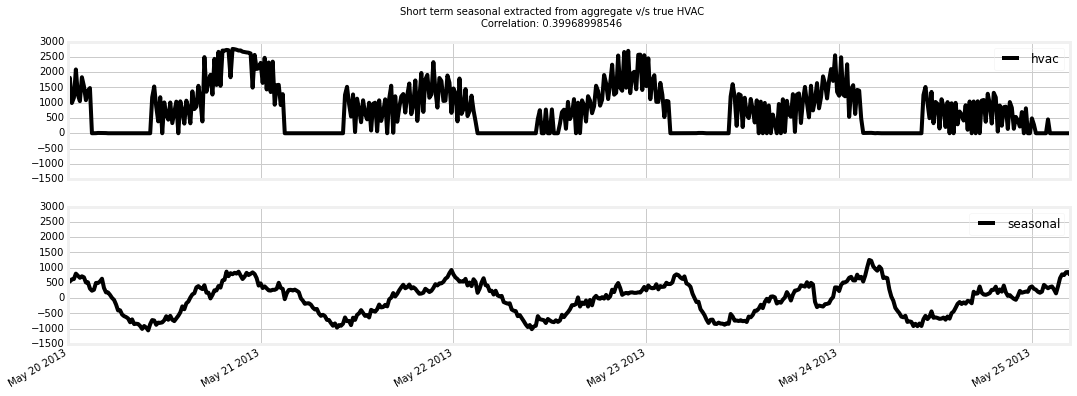

In [12]:
dfs_hvac[370][['hvac', 'seasonal']]['2013-05-20':].head(500).plot(subplots=True, figsize=(16,6))
plt.xlabel("")

corr = dfs_hvac[370][['hvac', 'seasonal']]['2013-05-20':'2013-10-30'].corr().values[0, 1]
plt.suptitle("Short term seasonal extracted from aggregate v/s true HVAC\nCorrelation: "+str(corr))
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/hvac_seasonal_aggregate_370.png")

In [23]:
dfs_hvac[26].sum()
s = dfs_hvac[26]['seasonal']
s-=s.min()

In [25]:
s.sum()
dfs_hvac[26].sum()

hvac        12969590.534972
seasonal    33236305.892454
trend       44090664.874186
dtype: float64

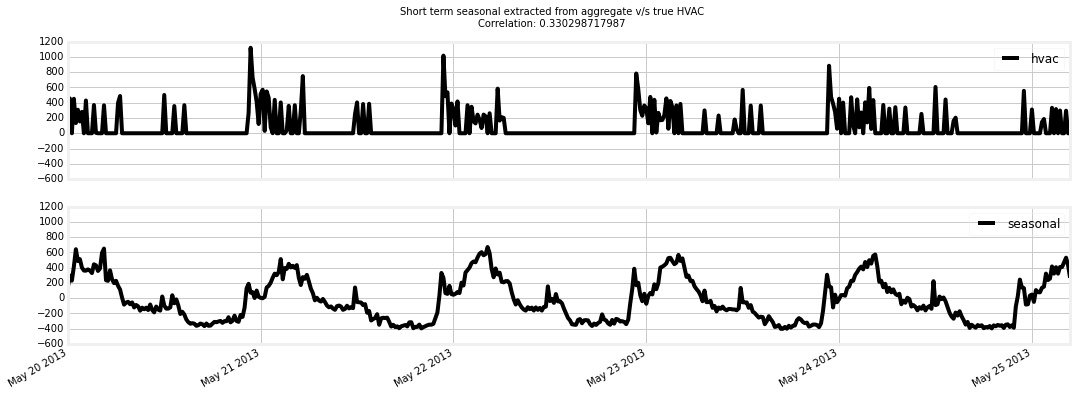

In [185]:
dfs_fridge[94][['hvac', 'seasonal']]['2013-05-20':].head(500).plot(subplots=True, sharey=True, figsize=(16,6))
plt.xlabel("")
corr = dfs_fridge[94][['hvac', 'seasonal']]['2013-05-20':'2013-10-30'].corr().values[0, 1]
plt.suptitle("Short term seasonal extracted from aggregate v/s true HVAC\nCorrelation: "+str(corr))
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/hvac_seasonal_aggregate_94.png")

In [9]:
def plot_correlations(df, appliance, feature):
    months = ["Jan", "Feb", "Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    if appliance is not "hvac":
        fig, ax = plt.subplots(ncols=6, nrows=2, sharey=True, sharex=True, figsize=(16,6))
        for month in range(1, 13):
            ax[(month-1)/6, (month-1)%6].scatter(df[feature],df['%s_%d' %(appliance, month)])
            ax[(month-1)/6, (month-1)%6].set_title(df[[feature, '%s_%d' %(appliance, month)]].corr().values[0, 1])
            ax[(month-1)/6, (month-1)%6].set_xlabel(months[month-1])
        ax[0,0].set_ylabel("Energy (kWh)")
        ax[1,0].set_ylabel("Energy (kWh)")
    else:
        fig, ax = plt.subplots(ncols=6, nrows=1, sharey=True, sharex=True, figsize=(16,3))
        for month in range(5, 11):
            ax[month-5].scatter(df[feature],df['%s_%d' %(appliance, month)])
            ax[month-5].set_title(df[[feature, '%s_%d' %(appliance, month)]].corr().values[0, 1])
            ax[month-5].set_xlabel(months[month-1])
        ax[0].set_ylabel("Energy (kWh)")
    plt.tight_layout()

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


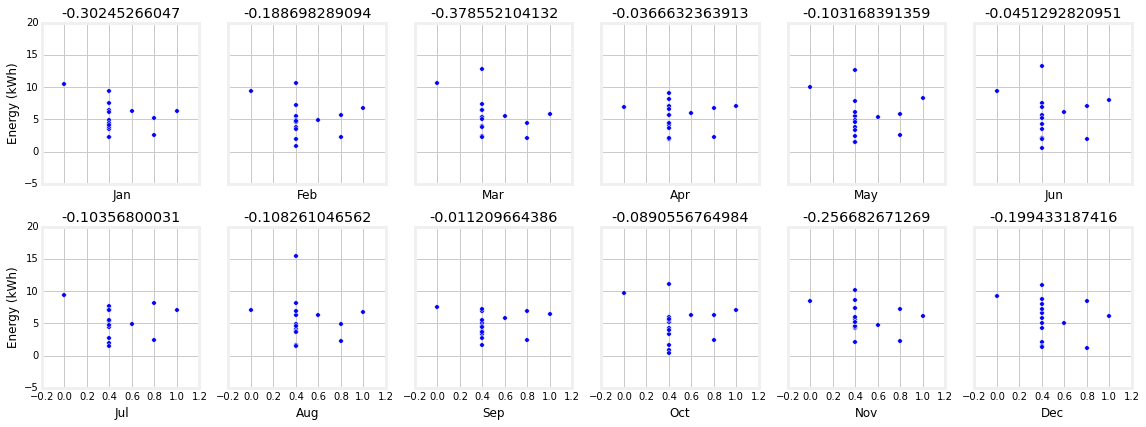

In [10]:
appliance="wm"
feature='total_occupants'
plot_correlations(df_appl[appliance], appliance, feature)
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/%s_%s.png" %(appliance, feature), bbox_inches="tight")

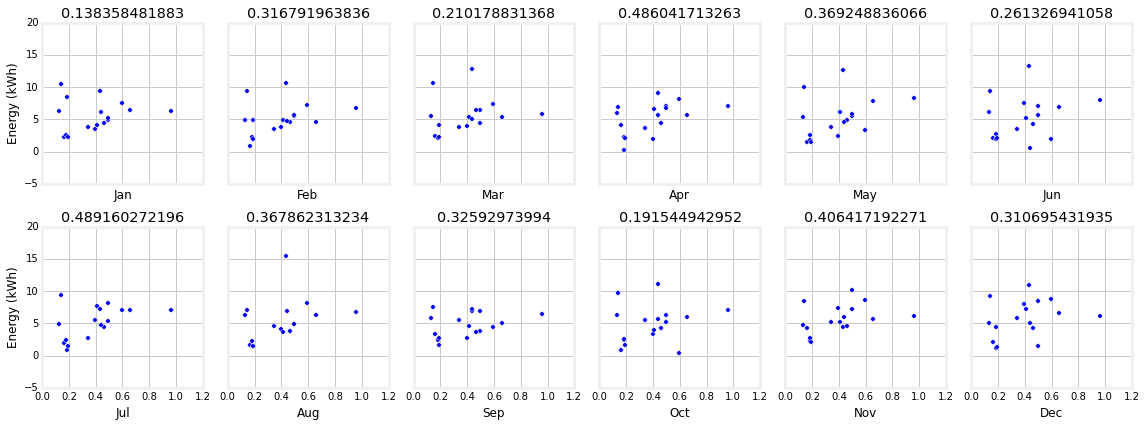

In [14]:
appliance="wm"
feature='daily_usage_2'
plot_correlations(df_appl[appliance], appliance, feature)
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/%s_%s.png" %(appliance, feature), bbox_inches="tight")

In [15]:
all_homes["wm"][0]

94

In [ ]:
g = {}
for home in all_homes["wm"][:]:
    print home
    temp_df = st['%d' %home]['2013'][['use']]
    temp_df["dayofweek"] = temp_df.index.dayofweek
    piv = pd.pivot_table(temp_df, index=["dayofweek"])
    g[home] = piv.div(piv.sum()).values.flatten()

In [60]:
o = {}
for home in all_homes["wm"][:]:
    print home
    temp_df = st['%d' %home]['2013'][['clotheswasher1']]
    temp_df["dayofweek"] = temp_df.index.dayofweek
    piv = pd.pivot_table(temp_df, index=["dayofweek"])
    o[home] = piv.div(piv.sum()).values.flatten()

    
    

94
370
545
624
2156
2242
2470
2814
3367
3456
3723
3967
5357
7769
9654
9922
9934


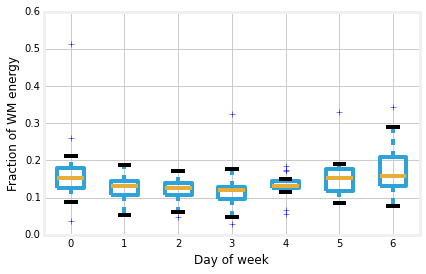

In [74]:
pd.DataFrame(o).T.plot(kind="box")
plt.ylabel("Fraction of WM energy")
plt.xlabel('Day of week')
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/wm_day.png")

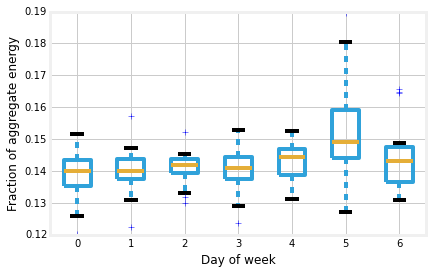

In [73]:
pd.DataFrame(g).T.plot(kind="box")
plt.ylabel("Fraction of aggregate energy")
plt.xlabel('Day of week')
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/aggregate_day.png")

In [66]:
pd.DataFrame(g).T[[6]].corrwith(pd.DataFrame(o).T[[6]])

6    0.581593
dtype: float64

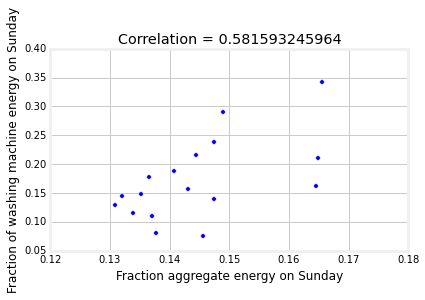

In [76]:
plt.scatter(pd.DataFrame(g).T[[6]],pd.DataFrame(o).T[[6]])
plt.xlabel("Fraction aggregate energy on Sunday")
plt.ylabel("Fraction of washing machine energy on Sunday")
plt.title("Correlation = "+str(pd.DataFrame(g).T[[6]].corrwith(pd.DataFrame(o).T[[6]]).values[0]))
plt.tight_layout()
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/wm_aggregate_correlation.png")

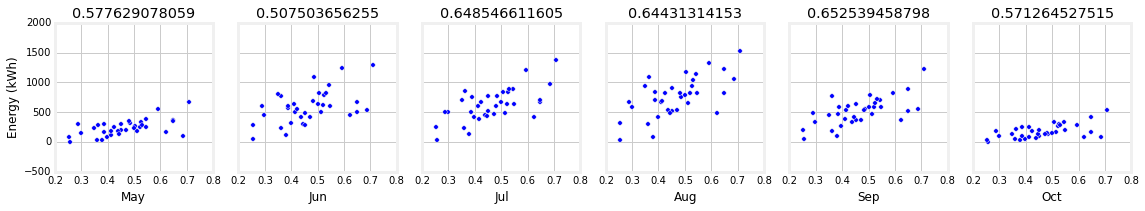

In [191]:
appliance="hvac"
feature='autocorr'
plot_correlations(df_appl[appliance], appliance, feature)
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/%s_%s.png" %(appliance, feature), bbox_inches="tight")

In [217]:
temp = (df_appl['hvac'][['hvac_%d' %i for i in range(1, 13)]]-df_appl['hvac'].ix[370][['hvac_%d' %i for i in range(1, 13)]]).abs().sum(axis=1)
temp = temp.drop(370)
temp.sort()
temp.head(5)

2814    333.353115
3367    412.534132
545     573.549753
2129    656.146658
1283    897.211371
dtype: float64

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(16, 6))
dfs_hvac[370]['trend'][:].plot(ax=ax,label="370")
dfs_hvac[94]['trend'][:].plot(ax=ax, label="94")
dfs_hvac[2814]['trend'][:].plot(ax=ax, label="2814")
dfs_hvac[3367]['trend'][:].plot(ax=ax, label="3367")

plt.legend()
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/hvac_trend.png", bbox_inches="tight")
plt.xlabel("")

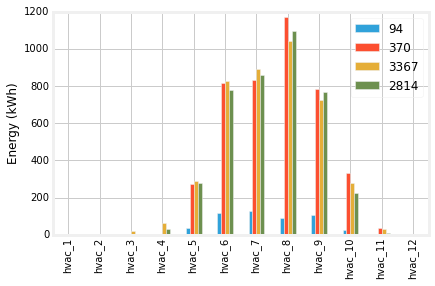

In [243]:
df_appl["hvac"].ix[[94, 370, 3367, 2814]][['hvac_%d' %i for i in range(1, 13)]].T.plot(kind="bar")
plt.ylabel("Energy (kWh)")
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/hvac_trend_gt.png")

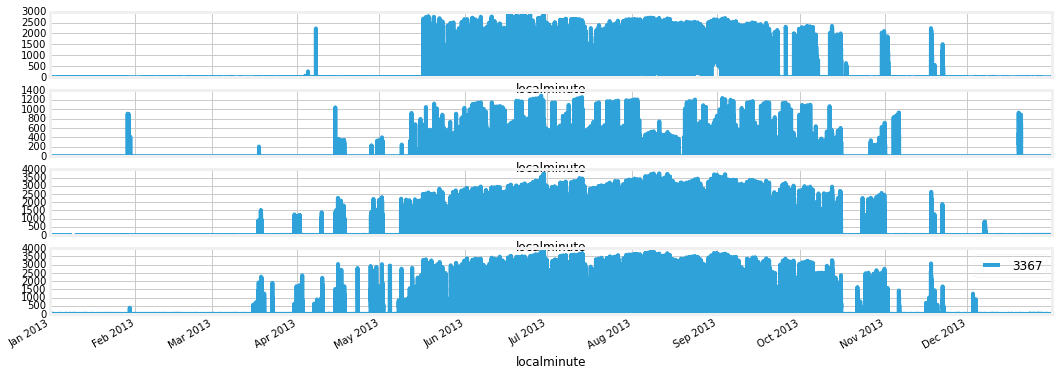

In [235]:
fig, ax = plt.subplots(sharex=True, nrows=4, figsize=(16,6))
dfs_hvac[370]['hvac'][:].plot(ax=ax[0],label="370")
dfs_hvac[94]['hvac'][:].plot(ax=ax[1], label="94")
dfs_hvac[2814]['hvac'][:].plot(ax=ax[2], label="2814")
dfs_hvac[3367]['hvac'][:].plot(ax=ax[3], label="3367")


plt.legend()

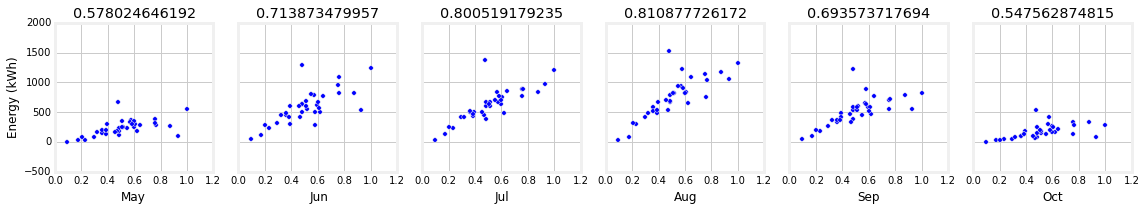

In [195]:
appliance="hvac"
feature='stdev_trend_weekly'
plot_correlations(df_appl[appliance], appliance, feature)
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/%s_%s.png" %(appliance, feature), bbox_inches="tight")

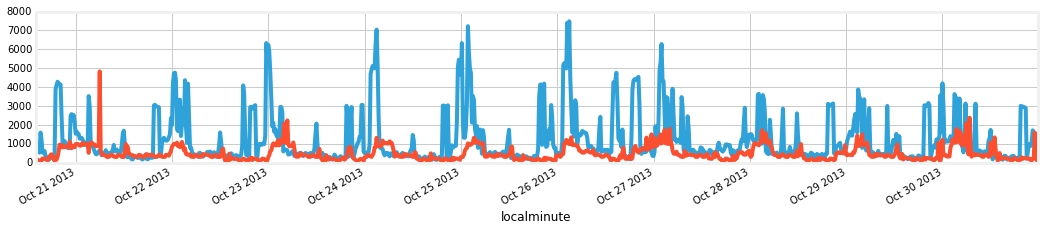

In [194]:
st['/26']['2013-05-01':'2013-10-30']['use'].resample("15T").tail(1000).plot(figsize=(16,3))
st['/94']['2013-05-01':'2013-10-30']['use'].resample("15T").tail(1000).plot(figsize=(16,3))



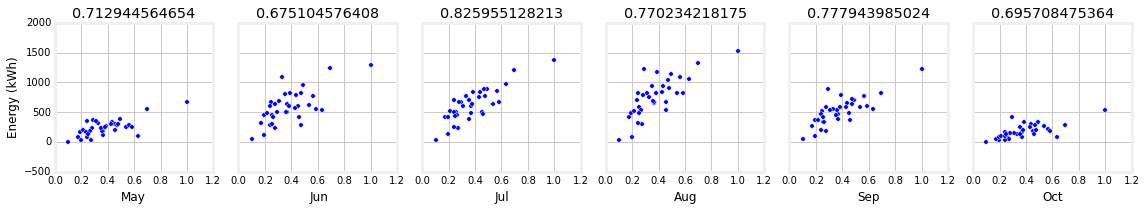

In [141]:
plot_correlations(df_appl['hvac'], 'hvac', 'stdev_seasonal_weekly')

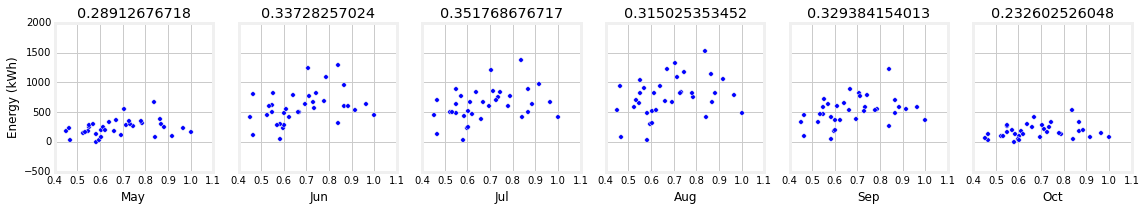

In [158]:
plot_correlations(df_appl['hvac'], 'hvac', 'temperature_corr')

In [ ]:
decompose()

In [26]:
import numpy as np

from scipy.special import gamma,psi
from scipy import ndimage
from scipy.linalg import det
from numpy import pi

from sklearn.neighbors import NearestNeighbors

__all__=['entropy', 'mutual_information', 'entropy_gaussian']

EPS = np.finfo(float).eps


def nearest_distances(X, k=1):
    '''
    X = array(N,M)
    N = number of points
    M = number of dimensions
    returns the distance to the kth nearest neighbor for every point in X
    '''
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    d, _ = knn.kneighbors(X) # the first nearest neighbor is itself
    return d[:, -1] # returns the distance to the kth nearest neighbor


def entropy_gaussian(C):
    '''
    Entropy of a gaussian variable with covariance matrix C
    '''
    if np.isscalar(C): # C is the variance
        return .5*(1 + np.log(2*pi)) + .5*np.log(C)
    else:
        n = C.shape[0] # dimension
        return .5*n*(1 + np.log(2*pi)) + .5*np.log(abs(det(C)))


def entropy(X, k=1):
    ''' Returns the entropy of the X.
    Parameters
    ===========
    X : array-like, shape (n_samples, n_features)
        The data the entropy of which is computed
    k : int, optional
        number of nearest neighbors for density estimation
    Notes
    ======
    Kozachenko, L. F. & Leonenko, N. N. 1987 Sample estimate of entropy
    of a random vector. Probl. Inf. Transm. 23, 95-101.
    See also: Evans, D. 2008 A computationally efficient estimator for
    mutual information, Proc. R. Soc. A 464 (2093), 1203-1215.
    and:
    Kraskov A, Stogbauer H, Grassberger P. (2004). Estimating mutual
    information. Phys Rev E 69(6 Pt 2):066138.
    '''

    # Distance to kth nearest neighbor
    r = nearest_distances(X, k) # squared distances
    n, d = X.shape
    volume_unit_ball = (pi**(.5*d)) / gamma(.5*d + 1)
    '''
    F. Perez-Cruz, (2008). Estimation of Information Theoretic Measures
    for Continuous Random Variables. Advances in Neural Information
    Processing Systems 21 (NIPS). Vancouver (Canada), December.
    return d*mean(log(r))+log(volume_unit_ball)+log(n-1)-log(k)
    '''
    return (d*np.mean(np.log(r + np.finfo(X.dtype).eps))
            + np.log(volume_unit_ball) + psi(n) - psi(k))


def mutual_information(variables, k=1):
    '''
    Returns the mutual information between any number of variables.
    Each variable is a matrix X = array(n_samples, n_features)
    where
      n = number of samples
      dx,dy = number of dimensions
    Optionally, the following keyword argument can be specified:
      k = number of nearest neighbors for density estimation
    Example: mutual_information((X, Y)), mutual_information((X, Y, Z), k=5)
    '''
    if len(variables) < 2:
        raise AttributeError(
                "Mutual information must involve at least 2 variables")
    all_vars = np.hstack(variables)
    return (sum([entropy(X, k=k) for X in variables])
            - entropy(all_vars, k=k))


def mutual_information_2d(x, y, sigma=1, normalized=False):
    """
    Computes (normalized) mutual information between two 1D variate from a
    joint histogram.
    Parameters
    ----------
    x : 1D array
        first variable
    y : 1D array
        second variable
    sigma: float
        sigma for Gaussian smoothing of the joint histogram
    Returns
    -------
    nmi: float
        the computed similariy measure
    """
    bins = (256, 256)

    jh = np.histogram2d(x, y, bins=bins)[0]

    # smooth the jh with a gaussian filter of given sigma
    ndimage.gaussian_filter(jh, sigma=sigma, mode='constant',
                                 output=jh)

    # compute marginal histograms
    jh = jh + EPS
    sh = np.sum(jh)
    jh = jh / sh
    s1 = np.sum(jh, axis=0).reshape((-1, jh.shape[0]))
    s2 = np.sum(jh, axis=1).reshape((jh.shape[1], -1))

    # Normalised Mutual Information of:
    # Studholme,  jhill & jhawkes (1998).
    # "A normalized entropy measure of 3-D medical image alignment".
    # in Proc. Medical Imaging 1998, vol. 3338, San Diego, CA, pp. 132-143.
    if normalized:
        mi = ((np.sum(s1 * np.log(s1)) + np.sum(s2 * np.log(s2)))
                / np.sum(jh * np.log(jh))) - 1
    else:
        mi = ( np.sum(jh * np.log(jh)) - np.sum(s1 * np.log(s1))
               - np.sum(s2 * np.log(s2)))

    return mi



In [30]:
X = df_appl['hvac']['autocorr'].values.reshape(-1,1)
X = df_appl['hvac']['aggregate_9'].values.reshape(-1,1)


Y = df_appl['hvac']['hvac_9'].values.reshape(-1,1)
mutual_information((X, Y), k=5)

-5.0437270126384792